# Plot model fit comparisons for simulation analysis 1

In [5]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from psifr import fr
from mindstorm import statplot
from cfr import framework
from cfr import figures

res_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS'])
fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim1'

data_file = res_dir / 'cfr_eeg_mixed.csv'
patterns_file = res_dir / 'cfr_patterns.hdf5'
os.makedirs(fig_dir, exist_ok=True)
figures.set_style()

## Load model fits

In [2]:
components = [
    'loc', 'cat', 'use', 'loc-cat', 'loc-use', 'cat-use', 'loc-cat-use'
]
models = [f'cmrs_fcf-{comp}' for comp in components]
model_names = ['I', 'C', 'D', 'IC', 'ID', 'CD', 'ICD']
res = framework.read_model_xvals(fit_dir, models, model_names)

In [3]:
res.groupby('model')['logl_test_list'].mean().sort_values()

model
D     -34.585169
C     -33.317897
CD    -33.149982
I     -32.431015
ID    -31.356594
IC    -30.887776
ICD   -30.759891
Name: logl_test_list, dtype: float64

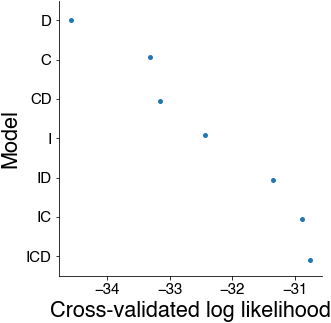

In [7]:
score = pd.DataFrame(res.groupby('model')['logl_test_list'].mean().sort_values())
g = sns.catplot(data=score.reset_index(), y='model', x='logl_test_list', color='C0', aspect=1)
g.set(xlabel='Cross-validated log likelihood', ylabel='Model')
g.savefig(fig_dir / 'model_comp_xval.pdf')

In [ ]:
score = pd.DataFrame(res.groupby('model')['logl_test_list'].mean().sort_values())
g = sns.catplot(data=score.reset_index(), y='model', x='logl_test_list', color='C0', aspect=1)

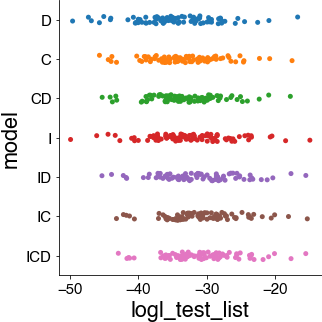

In [17]:
#pd.merge(res, res.groupby('model')['logl_test_list'].mean(), on='model')
m = res.reset_index('subject')
m['mean'] = res.groupby('model')['logl_test_list'].mean()
sns.catplot(data=m.reset_index().sort_values('mean'), y='model', x='logl_test_list')

## Calculate AIC weights

In [3]:
temp = res.loc[['I', 'C', 'D']].copy()
temp = framework.model_comp_weights(temp, stat='aic')
temp.groupby(['model'])['waic'].agg(['mean', 'sem', 'min', 'max']).T.round(4)

model,C,D,I
mean,0.2097,0.0,0.7903
sem,0.0763,0.0,0.0763
min,0.0000,0.0,0.0000
max,1.0000,0.0,1.0000


In [4]:
temp = res.loc[['IC', 'ID', 'CD']].copy()
temp = framework.model_comp_weights(temp, stat='aic')
temp.groupby(['model'])['waic'].agg(['mean', 'sem', 'min', 'max']).T.round(4)

model,CD,IC,ID
mean,0.0,0.7661,0.2339
sem,0.0,0.0753,0.0753
min,0.0,0.0000,0.0000
max,0.0,1.0000,1.0000


In [5]:
res = framework.model_comp_weights(res, stat='aic')

LINO NOT subset; don't know how to subset; dropped


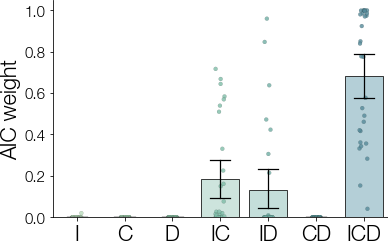

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
g = figures.plot_swarm_bar(
    data=res.reset_index(), x='model', y='waic', point_kind='strip', ax=ax
)
ax.set(ylabel='AIC weight');
fig.savefig(fig_dir / 'waic.pdf')

In [7]:
np.count_nonzero(res.loc['IC', 'waic'] > res.loc['ICD', 'waic'])

7

In [8]:
np.count_nonzero(res.loc['ID', 'waic'] > res.loc['ICD', 'waic'])

3

## Context component weights

In [9]:
param = res.loc['ICD', ['wr_loc', 'wr_cat', 'wr_use']]
df = pd.melt(
    param.reset_index(),
    id_vars='subject',
    value_name='Weight',
    var_name='Component',
)

LINO NOT subset; don't know how to subset; dropped


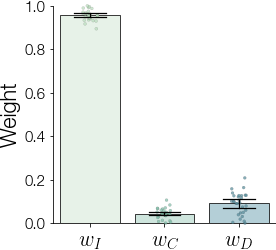

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
g = statplot.plot_swarm_bar(
    data=df.reset_index(),
    x='Component',
    y='Weight',
    point_kind='strip',
    point_kws={'clip_on': False},
    ax=ax,
)
ax.set(ylim=(0, 1), ylabel='Weight');
ax.set_xticks([0, 1, 2], ['$w_I$', '$w_C$', '$w_D$'], usetex=True)
fig.savefig(fig_dir / 'weights.pdf')

## Create a parameter table

In [11]:
table = figures.create_model_table(fit_dir, models, model_names)
table.to_latex(fig_dir / 'parameters1.tex', escape=False)
table

,I,C,D,IC,ID,CD,ICD
L_{FC},0.13 (0.01),0.75 (0.01),0.60 (0.03),0.10 (0.01),0.11 (0.01),0.73 (0.01),0.10 (0.01)
L_{CF},0.11 (0.01),0.80 (0.01),0.69 (0.01),0.09 (0.01),0.10 (0.01),0.75 (0.01),0.09 (0.01)
\phi_s,0.27 (0.07),0.08 (0.01),0.18 (0.02),0.04 (0.01),0.07 (0.01),0.05 (0.01),0.03 (0.01)
\phi_d,1.17 (0.19),0.41 (0.03),0.39 (0.07),1.26 (0.24),1.46 (0.26),0.35 (0.02),1.49 (0.25)
\beta_{\mathrm{enc}},0.72 (0.02),0.04 (0.00),0.08 (0.02),0.64 (0.02),0.66 (0.02),0.05 (0.01),0.62 (0.02)
\beta_{\mathrm{start}},0.67 (0.07),0.00 (0.00),0.03 (0.02),0.54 (0.07),0.66 (0.06),0.01 (0.01),0.54 (0.07)
\beta_{\mathrm{rec}},0.79 (0.02),0.96 (0.01),0.90 (0.05),0.86 (0.01),0.84 (0.01),0.94 (0.03),0.86 (0.01)
\theta_s,0.01 (0.00),0.01 (0.00),0.01 (0.00),0.01 (0.00),0.01 (0.00),0.01 (0.00),0.01 (0.00)
\theta_r,0.31 (0.01),0.31 (0.01),0.31 (0.01),0.31 (0.01),0.31 (0.01),0.31 (0.01),0.31 (0.01)
w_1,---,---,---,0.94 (0.00),0.83 (0.01),0.44 (0.03),0.96 (0.00)


In [12]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.23.1

mindstorm : 0.8.1
pandas    : 1.3.4
psifr     : 0.5.2
numpy     : 1.21.4
matplotlib: 3.5.0

